In [ ]:
# Library import

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

import calendar

import matplotlib.pyplot as plt
import seaborn as sns

delta=dt.timedelta(days=1)

In [5]:
# Get main path and other folders
s_mainpath=Path.cwd()
print(s_mainpath)
s_parentpath=s_mainpath.parent.parent.parent
print(s_parentpath)
# folderpath=s_parentpath.joinpath(r'DatosXM\Despacho\\')

# Ruta General
sRutaDesp=r'C:\Información XM\\Publico\\'

# Ruta General
sRutaLP=r'C:\Alejo\Eje de Planeación\Análisis Energético\\'

sRutaPrint=s_mainpath.joinpath('Print')

c:\Alejo\Eje de Planeación\Análisis Eléctrico\ScriptsPython
c:\Alejo


In [31]:
# Función para asignar los días de la semana a cada fecha, si es festivo se trata como un domingo
import holidays
co_holidays = holidays.Colombia()

def typedays(row,weekday):

     if weekday==True:
          return row['Fecha'].weekday()
     else:
          if row['Fecha'] in co_holidays:
               return 'F'
          elif row['Fecha'].weekday()==5:
               return 'S'
          elif row['Fecha'].weekday()==6:
               return 'F'
          else:
               return 'O'

In [6]:
filepath=s_parentpath.joinpath(sRutaLP,'ResumenLP.xlsx')

# Carga del nivel probabilístico del embalse
sheet_name='Generacion'
df_Gen=pd.read_excel(filepath, header=0,sheet_name=sheet_name)
# df_Gen=df_Gen.set_index('Embalse_Sinergox')

# Carga del nivel probabilístico del embalse
sheet_name='Consumo'
df_Cons=pd.read_excel(filepath, header=0,sheet_name=sheet_name)

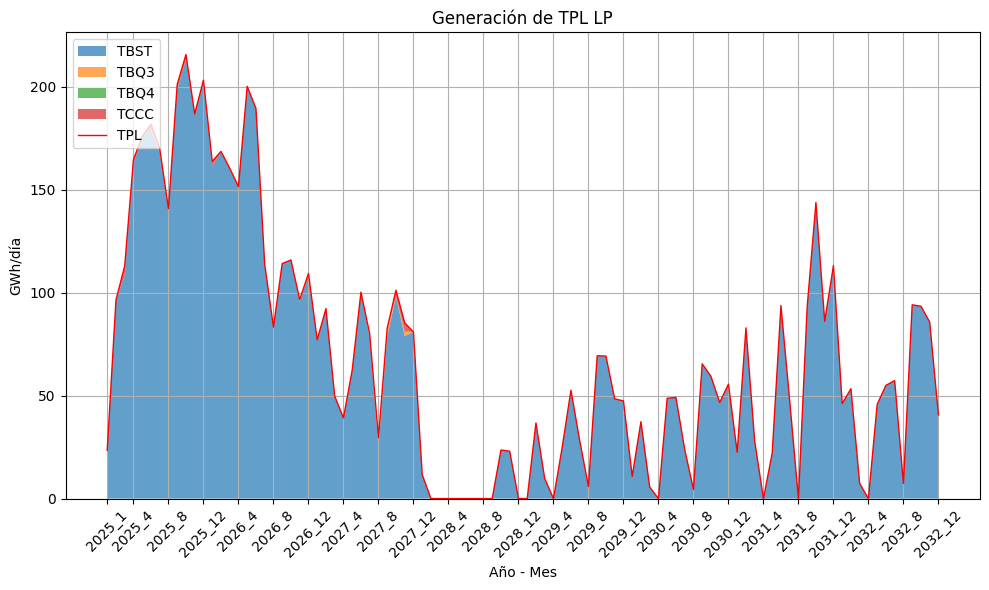

In [ ]:
df_GenP=df_Gen.copy()
df_GenP=df_GenP[(pd.to_datetime(df_GenP.Fecha)>=pd.to_datetime('2028-01-01'))]

years=list(set(list(df_GenP['Fecha'].dt.year)))
meses=list(set(list(df_GenP['Fecha'].dt.month)))

df_datesF=pd.DataFrame()

for year in years:

    for mes in meses:

        df_MeansM=pd.DataFrame()

        # Generar dataframe que contiene los días del mes dado
        last_day = calendar.monthrange(year, mes)[1]
        # Generar rango de fechas para el mes dado
        dates = pd.date_range(start=f"{year}-{mes:02d}-01", end=f"{year}-{mes:02d}-{last_day}", freq="D")
        df_dates = pd.DataFrame({'Fecha': dates})
        # Definir tipo de día
        df_dates['day_osf']=df_dates.apply(lambda row: typedays(row,weekday=False),axis=1)

        # Filtrar los datos para obtener la información por cada tipo de día
        # Ordianrio
        df_Aux=df_GenP[(df_GenP['Fecha'].isin([f"{year}-{mes:02d}-01",f"{year}-{mes:02d}-04",f"{year}-{mes:02d}-05"]))]
        means=df_Aux.mean()
        # Crear un nuevo DataFrame con la media
        df_means = pd.DataFrame([means], columns=df_Aux.columns)
        df_means['day_osf']='O'

        df_MeansM=pd.concat([df_MeansM,df_means],axis=0)

        # Sábado
        df_Aux=df_GenP[(df_GenP['Fecha'].isin([f"{year}-{mes:02d}-02"]))]
        means=df_Aux.mean()
        # Crear un nuevo DataFrame con la media
        df_means = pd.DataFrame([means], columns=df_Aux.columns)
        df_means['day_osf']='S'   

        df_MeansM=pd.concat([df_MeansM,df_means],axis=0)     

        # Sábado
        df_Aux=df_GenP[(df_GenP['Fecha'].isin([f"{year}-{mes:02d}-03"]))]
        means=df_Aux.mean()
        # Crear un nuevo DataFrame con la media
        df_means = pd.DataFrame([means], columns=df_Aux.columns)
        df_means['day_osf']='F'   

        df_MeansM=pd.concat([df_MeansM,df_means],axis=0)  

        df_MeansM=df_MeansM.drop(['Fecha'],axis=1)
        # df_MeansM=df_MeansM.reset_index(drop=True)

        # Merge data con el dataframe de los días
        df_dates=df_dates.merge(df_MeansM,left_on=['day_osf'],right_on=['day_osf'], how='left')[['Fecha','TBST', 'TBQ3', 'TBQ4', 'TCCC', 'TPL','day_osf']]

        # Concatenar la información en un dataframe final
        df_datesF=pd.concat([df_datesF,df_dates],axis=0)



df_GenP2=df_Gen.copy()
df_GenP2=df_GenP2[(pd.to_datetime(df_GenP2.Fecha)>=pd.to_datetime('2025-01-01')) & (pd.to_datetime(df_GenP2.Fecha)<=pd.to_datetime('2027-12-31'))]
df_GenP2['day_osf']=df_GenP2.apply(lambda row: typedays(row,weekday=False),axis=1)
df_GenP2=pd.concat([df_GenP2,df_datesF],axis=0)
# df_GenP2.to_csv('GeneraciónLPTPL.csv')
df_GenP2['year']=df_GenP2['Fecha'].dt.year
df_GenP2['mes']=df_GenP2['Fecha'].dt.month

df_GenMes=df_GenP2.groupby(['year','mes'])[['TBST', 'TBQ3', 'TBQ4', 'TCCC', 'TPL']].sum()
df_GenMes=df_GenMes.reset_index()
df_GenMes['y_m']=df_GenMes['year'].astype(str) + '_' + df_GenMes['mes'].astype(str)
df_GenMes

df_GenY=df_GenP2.groupby(['year'])[['TBST', 'TBQ3', 'TBQ4', 'TCCC', 'TPL']].sum()
df_GenY=df_GenY.reset_index()
# df_GenY.to_csv('GeneraciónLPTPL.csv')

# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Gráfico apilado de áreas
plt.stackplot(
    df_GenMes['y_m'],  # Eje x
    df_GenMes['TBST'], 
    df_GenMes['TBQ3'], 
    df_GenMes['TBQ4'], 
    df_GenMes['TCCC'], 
    labels=['TBST', 'TBQ3', 'TBQ4','TCCC'], 
    alpha=0.7  # Transparencia
)

# Línea adicional
sns.lineplot(x='y_m', y='TPL', data=df_GenMes, color='red', label='TPL', linewidth=1)

# Configurar la cantidad de etiquetas en el eje X
num_xticks = 25  # Número de etiquetas deseadas
x_indices = np.linspace(0, len(df_GenMes['y_m']) - 1, num_xticks, dtype=int)  # Índices seleccionados
plt.xticks(df_GenMes['y_m'][x_indices], rotation=45)  # Aplicar las etiquetas seleccionadas

# Personalización
plt.title('Generación de TPL LP')
plt.xlabel('Año - Mes')
plt.ylabel('GWh/día')
plt.legend(loc='upper left')  # Ubicación de la leyenda
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



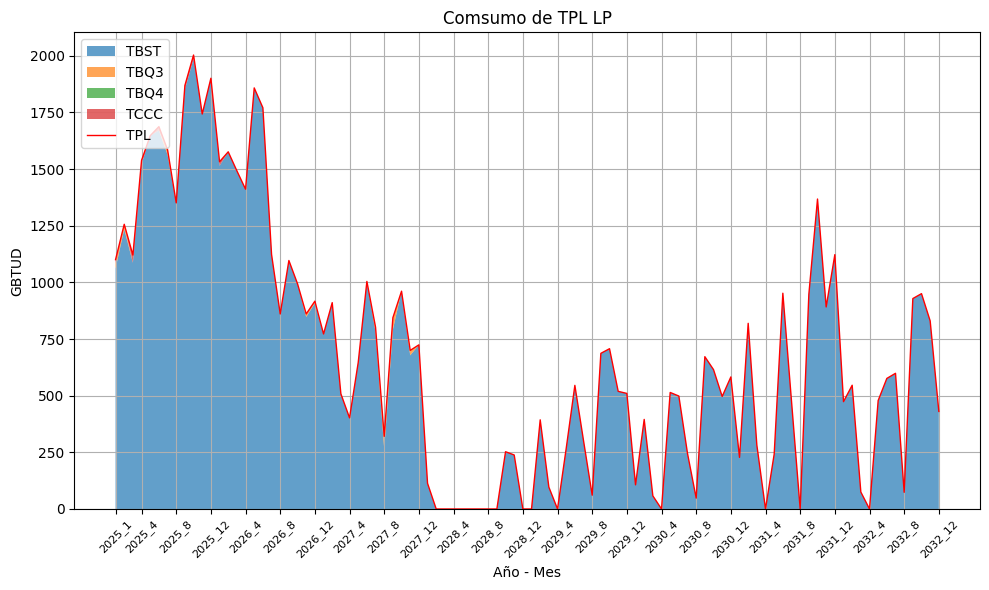

In [ ]:
df_ConsP=df_Cons.copy()
df_ConsP=df_ConsP[(pd.to_datetime(df_ConsP.Fecha)>=pd.to_datetime('2028-01-01'))]

years=list(set(list(df_ConsP['Fecha'].dt.year)))
meses=list(set(list(df_ConsP['Fecha'].dt.month)))

df_datesF=pd.DataFrame()

for year in years:

    for mes in meses:

        df_MeansM=pd.DataFrame()

        # Generar dataframe que contiene los días del mes dado
        last_day = calendar.monthrange(year, mes)[1]
        # Generar rango de fechas para el mes dado
        dates = pd.date_range(start=f"{year}-{mes:02d}-01", end=f"{year}-{mes:02d}-{last_day}", freq="D")
        df_dates = pd.DataFrame({'Fecha': dates})
        # Definir tipo de día
        df_dates['day_osf']=df_dates.apply(lambda row: typedays(row,weekday=False),axis=1)

        # Filtrar los datos para obtener la información por cada tipo de día
        # Ordianrio
        df_Aux=df_ConsP[(df_ConsP['Fecha'].isin([f"{year}-{mes:02d}-01",f"{year}-{mes:02d}-04",f"{year}-{mes:02d}-05"]))]
        means=df_Aux.mean()
        # Crear un nuevo DataFrame con la media
        df_means = pd.DataFrame([means], columns=df_Aux.columns)
        df_means['day_osf']='O'

        df_MeansM=pd.concat([df_MeansM,df_means],axis=0)

        # Sábado
        df_Aux=df_ConsP[(df_ConsP['Fecha'].isin([f"{year}-{mes:02d}-02"]))]
        means=df_Aux.mean()
        # Crear un nuevo DataFrame con la media
        df_means = pd.DataFrame([means], columns=df_Aux.columns)
        df_means['day_osf']='S'   

        df_MeansM=pd.concat([df_MeansM,df_means],axis=0)     

        # Sábado
        df_Aux=df_ConsP[(df_ConsP['Fecha'].isin([f"{year}-{mes:02d}-03"]))]
        means=df_Aux.mean()
        # Crear un nuevo DataFrame con la media
        df_means = pd.DataFrame([means], columns=df_Aux.columns)
        df_means['day_osf']='F'   

        df_MeansM=pd.concat([df_MeansM,df_means],axis=0)  

        df_MeansM=df_MeansM.drop(['Fecha'],axis=1)
        # df_MeansM=df_MeansM.reset_index(drop=True)

        # Merge data con el dataframe de los días
        df_dates=df_dates.merge(df_MeansM,left_on=['day_osf'],right_on=['day_osf'], how='left')[['Fecha','TBST', 'TBQ3', 'TBQ4', 'TCCC', 'TPL','day_osf']]

        # Concatenar la información en un dataframe final
        df_datesF=pd.concat([df_datesF,df_dates],axis=0)


df_ConsP2=df_Cons.copy()
df_ConsP2=df_ConsP2[(pd.to_datetime(df_ConsP2.Fecha)>=pd.to_datetime('2025-01-01')) & (pd.to_datetime(df_ConsP2.Fecha)<=pd.to_datetime('2027-12-31'))]
df_ConsP2['day_osf']=df_ConsP2.apply(lambda row: typedays(row,weekday=False),axis=1)
df_ConsP2=pd.concat([df_ConsP2,df_datesF],axis=0)
df_ConsP2['year']=df_ConsP2['Fecha'].dt.year
df_ConsP2['mes']=df_ConsP2['Fecha'].dt.month

df_ConsMes=df_ConsP2.groupby(['year','mes'])[['TBST', 'TBQ3', 'TBQ4', 'TCCC', 'TPL']].sum()
df_ConsMes=df_ConsMes.reset_index()
df_ConsMes['y_m']=df_ConsMes['year'].astype(str) + '_' + df_ConsMes['mes'].astype(str)
df_ConsMes

df_ConY=df_ConsP2.groupby(['year'])[['TBST', 'TBQ3', 'TBQ4', 'TCCC', 'TPL']].sum()
df_ConY=df_ConY.reset_index()

df_ConY.to_csv('ConsumoLPTPL.csv')

# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Gráfico apilado de áreas
plt.stackplot(
    df_ConsMes['y_m'],  # Eje x
    df_ConsMes['TBST'], 
    df_ConsMes['TBQ3'], 
    df_ConsMes['TBQ4'], 
    df_ConsMes['TCCC'], 
    labels=['TBST', 'TBQ3', 'TBQ4','TCCC'], 
    alpha=0.7  # Transparencia
)

# Línea adicional
sns.lineplot(x='y_m', y='TPL', data=df_ConsMes, color='red', label='TPL', linewidth=1)

# Configurar la cantidad de etiquetas en el eje X
num_xticks = 25  # Número de etiquetas deseadas
x_indices = np.linspace(0, len(df_ConsMes['y_m']) - 1, num_xticks, dtype=int)  # Índices seleccionados
plt.xticks(df_ConsMes['y_m'][x_indices], rotation=45, fontsize=8)  # Aplicar las etiquetas seleccionadas

# Personalización
plt.title('Comsumo de TPL LP')
plt.xlabel('Año - Mes')
plt.ylabel('GBTUD')
plt.legend(loc='upper left')  # Ubicación de la leyenda
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


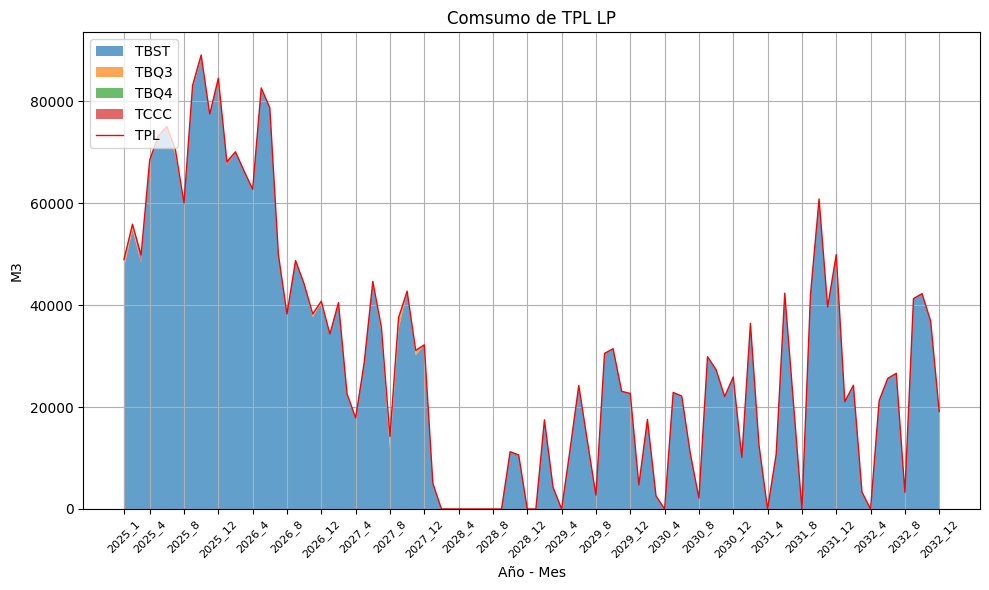

In [88]:
df_M3=df_ConsMes.copy()

df_M3['TBST']=(df_M3['TBST']*1000)/22.5
df_M3['TBQ3']=(df_M3['TBQ3']*1000)/22.5
df_M3['TBQ4']= (df_M3['TBQ4']*1000)/22.5
df_M3['TCCC']=(df_M3['TCCC']*1000)/22.5
df_M3['TPL']=(df_M3['TPL']*1000)/22.5
# Configuración del gráfico
plt.figure(figsize=(10, 6))

# Gráfico apilado de áreas
plt.stackplot(
    df_M3['y_m'],  # Eje x
    df_M3['TBST'], 
    df_M3['TBQ3'], 
    df_M3['TBQ4'], 
    df_M3['TCCC'], 
    labels=['TBST', 'TBQ3', 'TBQ4','TCCC'], 
    alpha=0.7  # Transparencia
)

# Línea adicional
sns.lineplot(x='y_m', y='TPL', data=df_M3, color='red', label='TPL', linewidth=1)

# Configurar la cantidad de etiquetas en el eje X
num_xticks = 25  # Número de etiquetas deseadas
x_indices = np.linspace(0, len(df_M3['y_m']) - 1, num_xticks, dtype=int)  # Índices seleccionados
plt.xticks(df_M3['y_m'][x_indices], rotation=45, fontsize=8)  # Aplicar las etiquetas seleccionadas

# Personalización
plt.title('Comsumo de TPL LP')
plt.xlabel('Año - Mes')
plt.ylabel('M3')
plt.legend(loc='upper left')  # Ubicación de la leyenda
plt.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()